# Explore here

In [ ]:
import pandas as pd


url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
sales_data = pd.read_csv(url)


sales_data.head()


,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


D


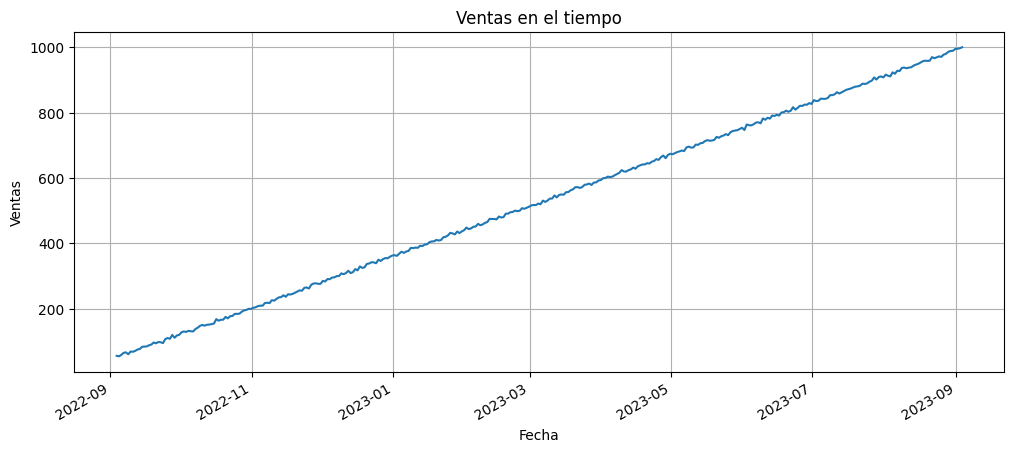

In [ ]:

sales_data['date'] = pd.to_datetime(sales_data['date'])
sales_data.set_index('date', inplace=True)


print(sales_data.index.inferred_freq)


import matplotlib.pyplot as plt

sales_data['sales'].plot(figsize=(12, 5), title="Ventas en el tiempo")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.grid()
plt.show()


In [7]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(sales_data['sales'])
print(f"p-value: {adf_test[1]}")


p-value: 0.9861899815311064


Tendencia Ascendente
Tensor diario 
No es estacionaria 
hay pequeños ruidos diarios 

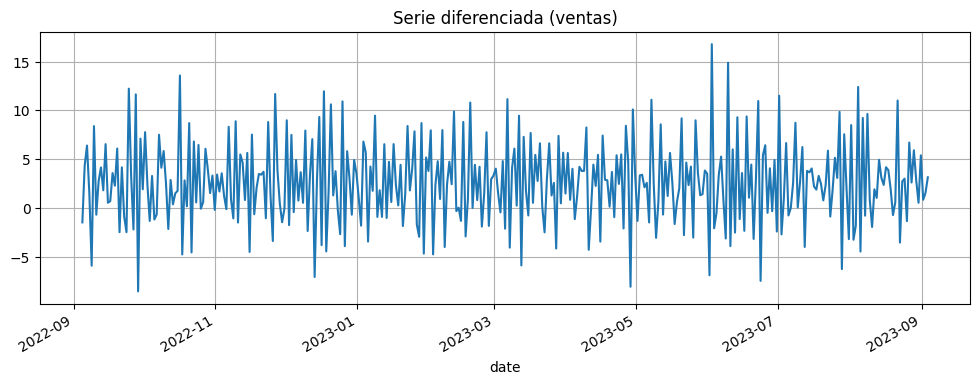

In [ ]:
# Diferenciar la serie para eliminar tendencia
sales_diff = sales_data['sales'].diff().dropna()

sales_diff.plot(figsize=(12, 4), title="Serie diferenciada (ventas)")
plt.grid()
plt.show()


In [9]:
from statsmodels.tsa.stattools import adfuller

adf_test_diff = adfuller(sales_diff)
print(f"p-value: {adf_test_diff[1]}")


p-value: 5.212954111417404e-16


Análisis de la variabilidad

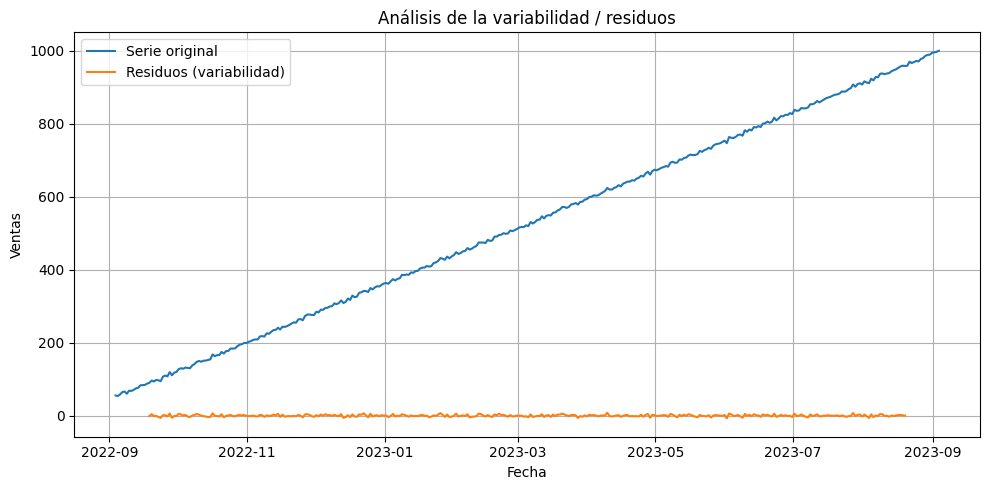

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns


decomposition = seasonal_decompose(sales_data['sales'], model='additive', period=30)  # asumimos periodicidad mensual


residual = decomposition.resid
ts = sales_data['sales']


fig, axis = plt.subplots(figsize=(10, 5))

sns.lineplot(data=ts, label='Serie original')
sns.lineplot(data=residual, label='Residuos (variabilidad)')

plt.title("Análisis de la variabilidad / residuos")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.grid()
plt.tight_layout()
plt.show()


resiudos pequeños 

Funciones de autocorrelación

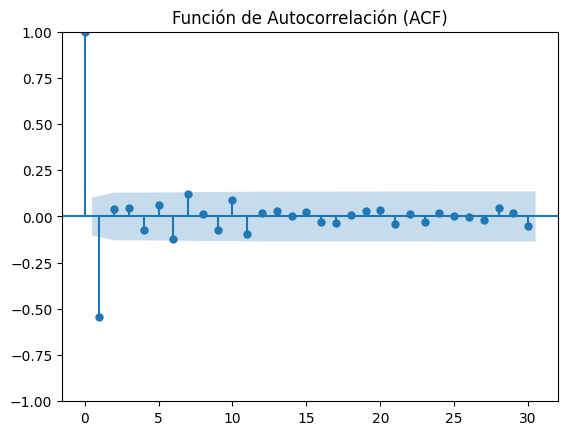

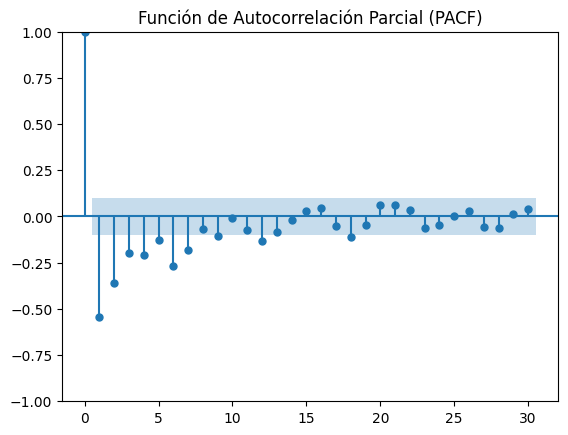

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Autocorrelación (ACF)
plot_acf(sales_diff, lags=30)
plt.title("Función de Autocorrelación (ACF)")
plt.show()

# Autocorrelación Parcial (PACF)
plot_pacf(sales_diff, lags=30)
plt.title("Función de Autocorrelación Parcial (PACF)")
plt.show()


entrenar

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Entrenar modelo ARIMA(1,1,1)
model = ARIMA(sales_data['sales'], order=(1,1,1))
model_fit = model.fit()


print(model_fit.summary())


/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  366
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1049.230
Date:                Sun, 18 May 2025   AIC                           2104.459
Time:                        14:49:03   BIC                           2116.159
Sample:                    09-03-2022   HQIC                          2109.109
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.002    637.971      0.000       0.997       1.003
ma.L1         -0.9993      0.819     -1.220      0.223      -2.605       0.607
sigma2        18.1498     14.910      1.217      0.2

In [15]:
# Últimos 30 días como test
train = sales_data['sales'][:-30]
test = sales_data['sales'][-30:]


In [16]:
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()


/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [17]:
# Predecir los próximos 30 pasos
preds = model_fit.forecast(steps=30)
preds.index = test.index  


Comparar con los datos reales

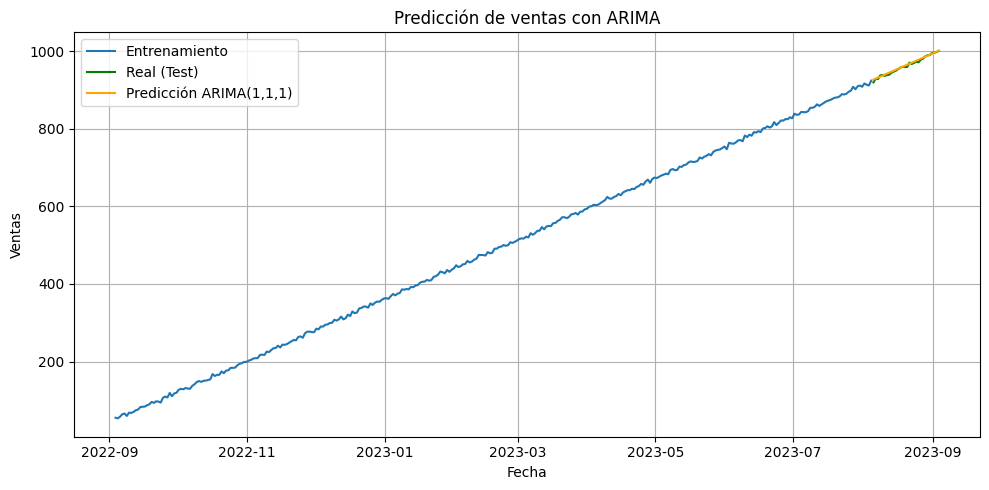

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Real (Test)', color='green')
plt.plot(preds.index, preds, label='Predicción ARIMA(1,1,1)', color='orange')
plt.title("Predicción de ventas con ARIMA")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


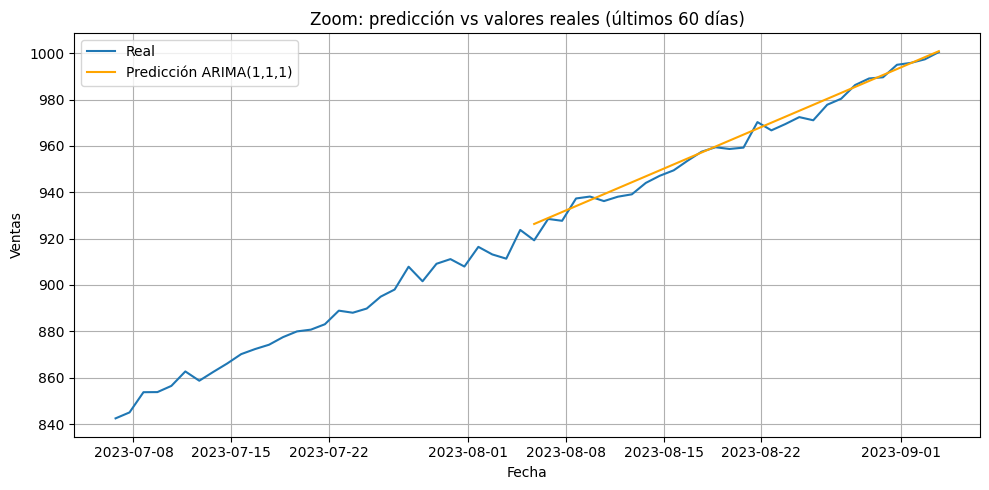

In [19]:
# Concatenamos últimas 30 fechas de entrenamiento + test
zoom_range = sales_data['sales'][-60:]  # últimos 60 días

plt.figure(figsize=(10, 5))
plt.plot(zoom_range.index, zoom_range, label='Real')
plt.plot(preds.index, preds, label='Predicción ARIMA(1,1,1)', color='orange')
plt.title("Zoom: predicción vs valores reales (últimos 60 días)")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
import joblib

# Guardar el modelo entrenado
joblib.dump(model_fit, 'modelo_arima_ventas.pkl')


['modelo_arima_ventas.pkl']